In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import model_tools as mt
from IPython.display import clear_output

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

import torch
from pytorch_forecasting.metrics import QuantileLoss, MAPE, RMSE, MAE, SMAPE
from pytorch_forecasting import Baseline, TimeSeriesDataSet, TemporalFusionTransformer

ModuleNotFoundError: No module named 'model_tools'

Set settings

In [2]:
settings = mt.load_settings()
loss_funcs = {
    "val_SMAPE": SMAPE(), 
    "val_MAE":   MAE(),
    "val_RMSE":  RMSE(),
    "val_MAPE":  MAPE(),
}
# Dynamic path updates
df = pd.read_csv(settings["data"])
settings["data_shape"] = df.shape
print(settings["data_shape"])
settings["loss_func"] = loss_funcs.get(settings["loss_name"], QuantileLoss())
settings["base_path"] = f"{settings['base_path']}{settings['lstm_layers']}"
settings["model_path"] = f"{settings['base_path']}/{settings['name']}/{settings['name']}.pth"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_CUDA_ALLOC_SYNC'] = "1"
torch.cuda.empty_cache()
torch.set_float32_matmul_precision(settings["float_precision"]) # use 'high' for more accurate models
torch.set_grad_enabled(True)
print(settings["accelerator"])

# Create copy in .py file format
mt.ipynb_to_py(f"{settings['file']}")


(8259, 84)
cuda


Create Baseline Model

Dropped 20 columns due to low feature correlation with target
New data shape: (8259, 64)


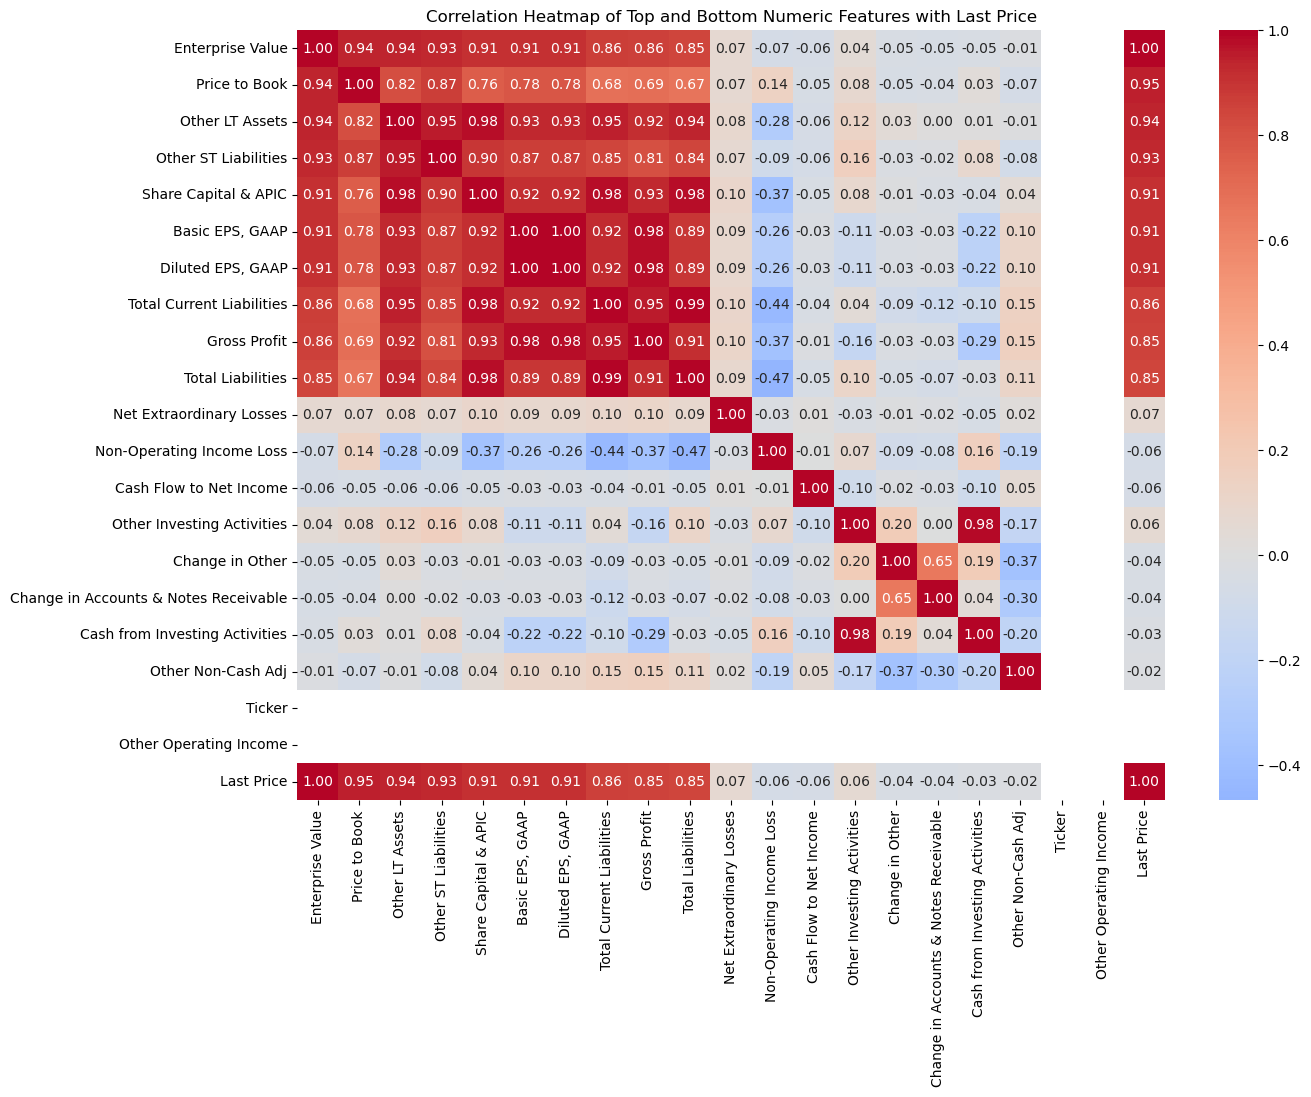

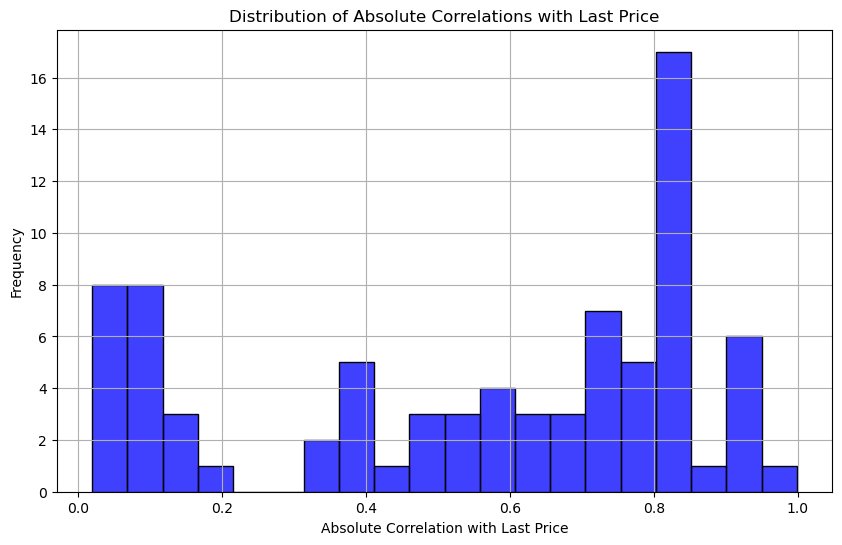

In [3]:
# Load and preprocess data
original = pd.read_csv(settings["data"])

# Preprocess data, settings and check correlations
data, settings = mt.preprocess(original, settings)

# Create dataset
max_encoder_length = len(data) // settings['n_splits']
training_cutoff = data["Datetime"].max() - settings["max_prediction_length"]
unknown_reals = list(settings["protected_columns"])

training = TimeSeriesDataSet(
    data[lambda x: x.Datetime <= training_cutoff],
    time_idx="Datetime",
    target=settings["target"], 
    group_ids=["Ticker"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=settings["max_prediction_length"],
    static_reals=["Ticker"], 
    time_varying_unknown_reals=unknown_reals,
    add_relative_time_idx=True,
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# Create dataloaders
train_dataloader = training.to_dataloader(
    train=True, 
    batch_size=settings["batch_size"], 
    num_workers=20
)
val_dataloader = validation.to_dataloader(
    train=False,
    batch_size=settings["batch_size"] * 10,
    num_workers=20
)

Configure Network, Trainer, and Model

In [4]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [5]:
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor=settings["loss_name"],
    patience=10,
)
ckpt_callback = ModelCheckpoint(
    monitor=settings["loss_name"],
    dirpath=f"{settings['base_path']}/{settings['name']}/study_ckpts/",
    filename='{val_loss:.3f}-{epoch:02d}',
    every_n_epochs=1,
)
logger = TensorBoardLogger(
    save_dir=f"lightning_logs/lstm_layers_{settings['lstm_layers']}/", 
    name=settings["name"],
)
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    devices=-1,
    accelerator=settings["accelerator"],
    max_epochs=settings["max_train_epochs"],
    gradient_clip_val=settings["gradient_clip_val"],
    #limit_train_batches=50,  # coment in for training, running validation every 30 batches
    #fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback, ckpt_callback,],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=settings["learning_rate"],
    lstm_layers=settings["lstm_layers"],
    hidden_size=settings["hidden_size"],
    hidden_continuous_size=settings["hidden_continuous_size"],
    attention_head_size=settings["attention_head_size"],
    dropout=settings["dropout"],
    output_size=1,
    loss=settings["loss_func"],
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=settings["reduce_on_plateau_patience"],
)
tft.to(settings["accelerator"])

# Check if the file exists to continue training
if os.path.exists(settings["model_path"]):
    checkpoint = torch.load(settings["model_path"])
    tft.load_state_dict(checkpoint["state_dict"])
    print("Study loaded successfully.")
else:
    print(f"The file {settings['model_path']} does not exist.")

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The file config_history/lstm_layers_21/testies/testies.pth does not exist.
Number of parameters in network: 63.3k


Train Model

In [6]:
trainer.fit(
   tft,
   train_dataloaders=train_dataloader,
   val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAPE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 184   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.6 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 3.8 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 3.8 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Save the model

In [7]:
# load the best model according to loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# Save the best model
mt.save_model(best_tft, trainer, settings)

Evaluate Performance (vs Baseline)

Mean TFT MAPE:      0.2097
Mean Baseline MAPE: 0.0655
Mean TFT RMSE:      0.4071
Mean Baseline RMSE: 0.0590
Last TFT MAPE:      0.0259
Last Baseline MAPE: 0.1520
Last TFT RMSE:      0.0081
Last Baseline RMSE: 0.2784


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x275 with 1 Axes>,
 'decoder_variables': <Figure size 700x225 with 1 Axes>}

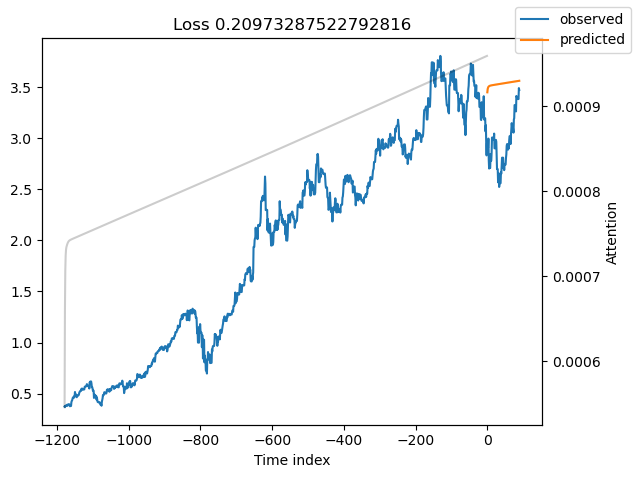

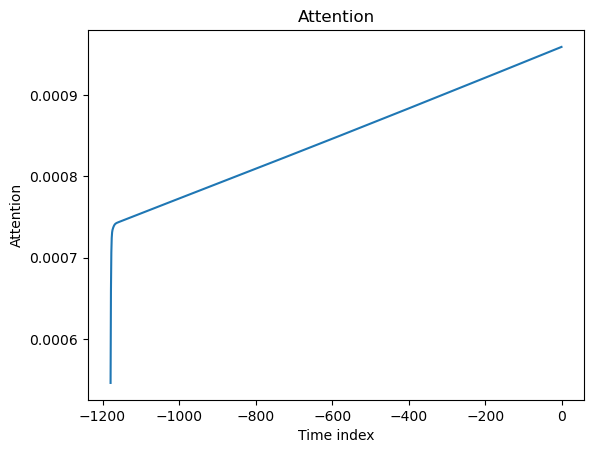

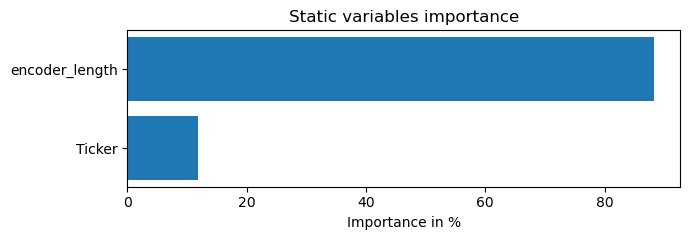

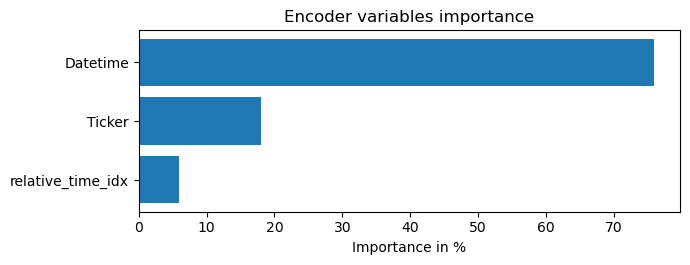

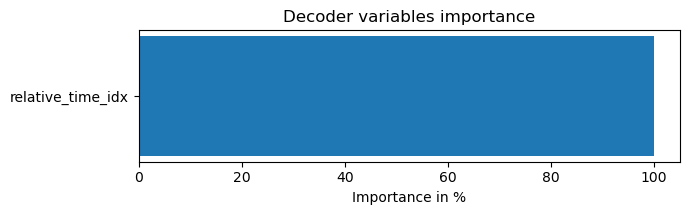

In [8]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator=settings["accelerator"]))
best_predictions = best_tft.predict(val_dataloader, mode="raw", return_y=True, return_x=True, trainer_kwargs=dict(accelerator=settings["accelerator"]))

# Taking the mean of the tensor
mean_baseline_mape = torch.mean(MAPE('mean').loss(baseline_predictions.output, baseline_predictions.y[0]))
mean_baseline_rmse = torch.mean(RMSE('mean').loss(baseline_predictions.output, baseline_predictions.y[0]))

# Taking the last value of the tensor
last_baseline_mape = MAPE('mean').loss(baseline_predictions.output, baseline_predictions.y[0])[:,-1]
last_baseline_rmse = RMSE('mean').loss(baseline_predictions.output, baseline_predictions.y[0])[:,-1]

# Taking the mean of the tensor
mean_tft_mape = torch.mean(MAPE('mean').loss(best_predictions.output.prediction, best_predictions.y[0]))
mean_tft_rmse = torch.mean(RMSE('mean').loss(best_predictions.output.prediction, best_predictions.y[0]))

# Taking the last value of the tensor
last_tft_mape = MAPE('mean').loss(best_predictions.output.prediction, best_predictions.y[0])[:,-1]
last_tft_rmse = RMSE('mean').loss(best_predictions.output.prediction, best_predictions.y[0])[:,-1]

clear_output(wait=True)
print(f"Mean TFT MAPE:      {mean_tft_mape.item():.4f}")
print(f"Mean Baseline MAPE: {mean_baseline_mape.item():.4f}")
print(f"Mean TFT RMSE:      {mean_tft_rmse.item():.4f}")
print(f"Mean Baseline RMSE: {mean_baseline_rmse.item():.4f}")
print(f"Last TFT MAPE:      {last_tft_mape.item():.4f}")
print(f"Last Baseline MAPE: {last_baseline_mape.item():.4f}")
print(f"Last TFT RMSE:      {last_tft_rmse.item():.4f}")
print(f"Last Baseline RMSE: {last_baseline_rmse.item():.4f}")

best_tft.plot_prediction(best_predictions.x, best_predictions.output, idx=0, add_loss_to_title=True)
interpretation = best_tft.interpret_output(best_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)